In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Time\ Series\ Forecasting

/content/drive/MyDrive/Time Series Forecasting


In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

df = pd.read_csv("Aquifer_Petrignano_Weekly.csv")
df.head()

,Date,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry,Rainfall
0,2009-01-01,-31.048571,1.657143,-28164.918857,2.371429,0.0
1,2009-01-08,-30.784286,4.571429,-29755.789714,2.314286,2.0
2,2009-01-15,-30.420000,7.528571,-25463.190857,2.300000,0.2
3,2009-01-22,-30.018571,6.214286,-23854.422857,2.500000,4.1
4,2009-01-29,-29.790000,5.771429,-25210.532571,2.500000,9.9


### 单变量时间序列模型

只使用`Depth_to_Groundwater`属性进行预测，采用单变量预测的方式。将现有数据按季度进行划分，取最后一个季度的数据作为测试数据。



In [4]:
# 调整Date的格式
df['Date'] = pd.to_datetime(df.Date, format = '%Y-%m-%d')

# 获取季度下标
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['quarter_idx'] = (df.quarter != df.quarter.shift(1)).cumsum()

# 设置目标属性
target = 'Depth_to_Groundwater'
features = [feature for feature in df.columns if feature != target]

# 季度总数
N_SPLITS = 46

# 训练数据
X = df[df.quarter_idx < N_SPLITS][features]
y = df[df.quarter_idx < N_SPLITS][target]

# 最后一个季度的数据作为测试数据
X_test = df[df.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df[df.quarter_idx == N_SPLITS][target].reset_index(drop=True)

In [5]:
from datetime import date

def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    folds = np.linspace(0, N_SPLITS-3, num=N_SPLITS-2)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2018, 6, 30), date(2020, 6, 30)])
    ax[0].set_ylim([-27, -23])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid, y_valid_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='Date', fontsize=14)
    ax[0].set_ylabel(ylabel='Depth to Groundwater P25', fontsize=14)

    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
    ax[1].set_ylim([0, 4])   
    plt.show()

#### 朴素算法

$\hat{y}_{t+1}=t_t$

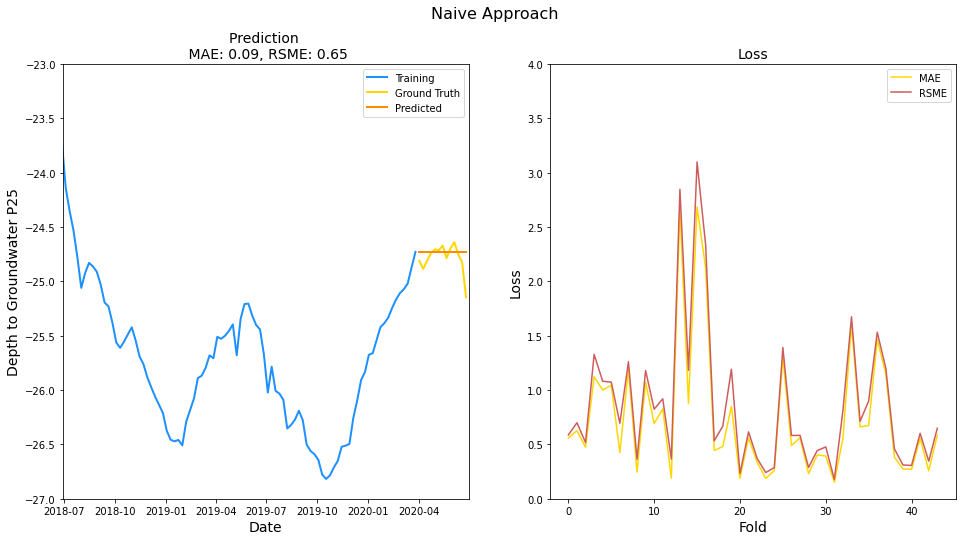

In [6]:
score_mae = []
score_rsme = []
for valid_quarter_id in range(2, N_SPLITS):
    # 准备训练集和验证集数据
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # 初始化预测结果
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # 预测方法：朴素算法
    y_valid_pred = y_valid_pred * y_train.iloc[-1]
    
    # 计算评价指标
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.ones(len(X_test))) * y.iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Naive Approach')

#### 滑动平均

window_size = 4 weeks

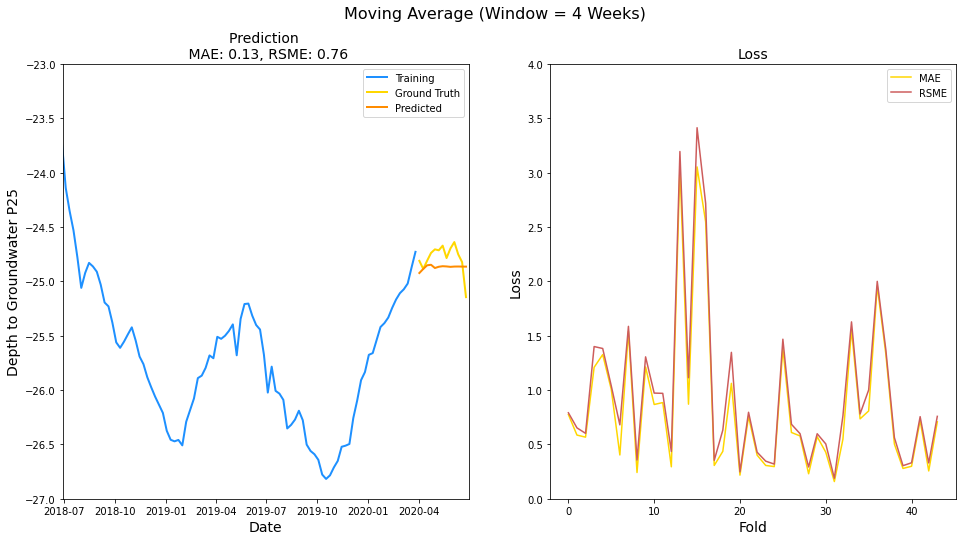

In [7]:
score_mae = []
score_rsme = []
for valid_quarter_id in range(2, N_SPLITS):
    # 准备训练集和验证集数据
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # 初始化预测结果
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # 预测方法：滑动平均   
    for i in range(len(y_valid_pred)):
        y_valid_pred.iloc[i] = y_train.append(y_valid_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]
        
    # 计算评价指标
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.zeros(len(X_test)))

for i in range(len(y_pred)):
    y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(4).mean().iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Average (Window = 4 Weeks)')

window_size = 8 weeks

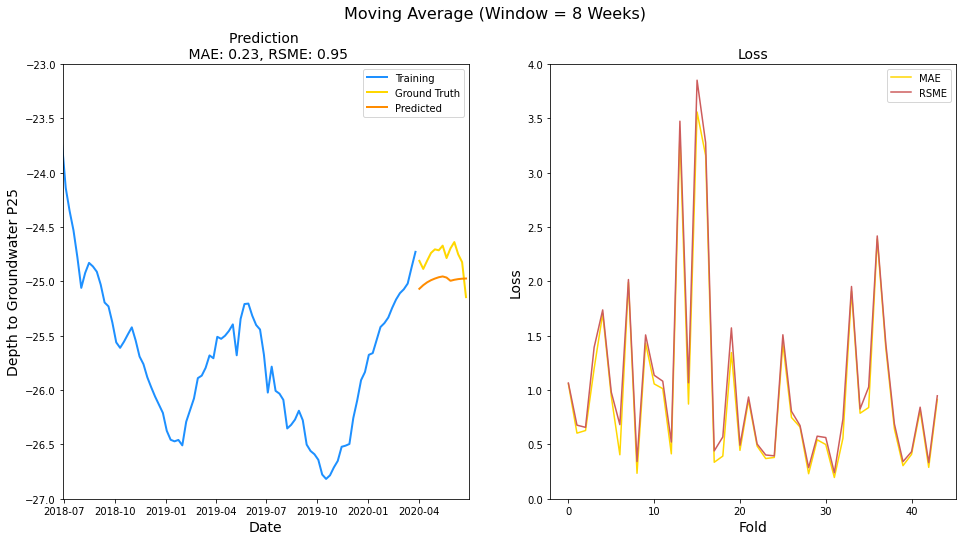

In [8]:
score_mae = []
score_rsme = []
for valid_quarter_id in range(2, N_SPLITS):
    # 准备训练集和验证集数据
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # 初始化预测结果
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # 预测方法：滑动平均   
    for i in range(len(y_valid_pred)):
        y_valid_pred.iloc[i] = y_train.append(y_valid_pred.iloc[:(i)]).reset_index(drop=True).rolling(8).mean().iloc[-1]
        
    # 计算评价指标
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.zeros(len(X_test)))

for i in range(len(y_pred)):
    y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(8).mean().iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Average (Window = 8 Weeks)')

window_size = 2 weeks

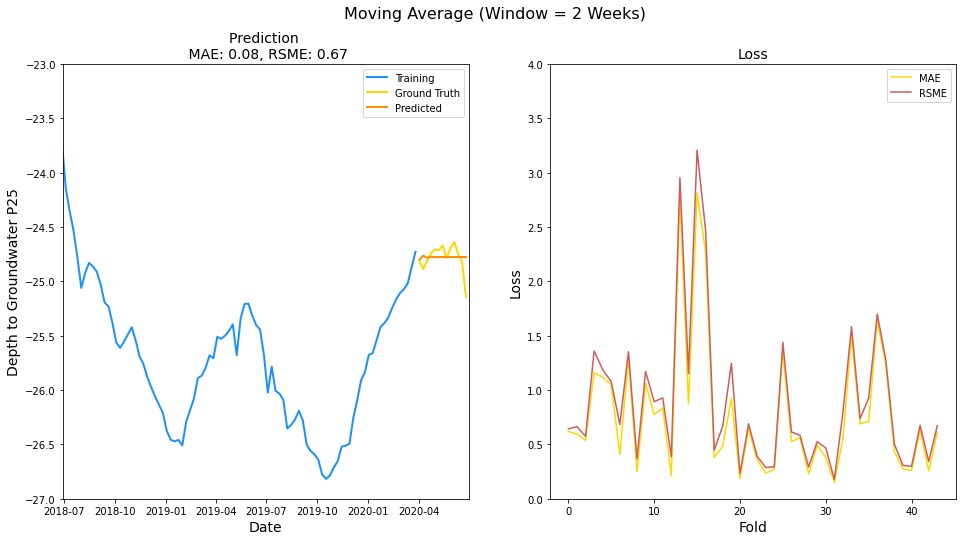

In [9]:
score_mae = []
score_rsme = []
for valid_quarter_id in range(2, N_SPLITS):
    # 准备训练集和验证集数据
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # 初始化预测结果
    y_valid_pred = pd.Series(np.ones(len(y_valid)))
    
    # 预测方法：滑动平均   
    for i in range(len(y_valid_pred)):
        y_valid_pred.iloc[i] = y_train.append(y_valid_pred.iloc[:(i)]).reset_index(drop=True).rolling(2).mean().iloc[-1]
        
    # 计算评价指标
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

y_pred = pd.Series(np.zeros(len(X_test)))

for i in range(len(y_pred)):
    y_pred.iloc[i] = y.append(y_pred.iloc[:(i)]).reset_index(drop=True).rolling(2).mean().iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Moving Average (Window = 2 Weeks)')

对比window_size分别等于2,4,8的三种情况，可以发现：
- 总体来看，滑动平均的方法对变化不敏感；
- window_size越大，变化越滞后。

#### ARIMA

ARIMA方法主要由三部分构成：

1. AR（Auto Regression）模型

自回归模型描述当前值与历史值之间的关系，用变量自身的历史时间数据对自身进行预测。

一般的$p$阶自回归模型：

$$y_t=\alpha_1 y_{t-1}+\alpha_2 y_{t-2}+\dots+\alpha_p y_{t-p}+u_t$$

如果随机扰动项是一个白噪声（$u_t=\epsilon_t$），则称为一个纯AR过程，记为：

$$y_t=\alpha_1 y_{t-1}+\alpha_2 y_{t-2}+\dots+\alpha_p y_{t-p}+\epsilon_t$$

自回归模型首先需要确定一个阶数$p$，表示用几期的历史值来预测当前值。

自回归模型有很多的限制：

（1）自回归模型是用自身的数据进行预测

（2）时间序列数据必须具有平稳性

（3）自回归只适用于预测与自身前期相关的现象（时间序列的自相关性）

2. MA（Moving Average）模型

在AR模型中，如果$u_t$不是一个白噪声，通常认为它是一个$q$阶的移动平均，即

$$u_t=\epsilon_t+\beta_1 \epsilon_{t-1}+\beta_2 \epsilon_{t-2}+\dots+\beta_q \epsilon_{t-q}$$

特别的，当$y_t=u_t$，即时间序列当前值与历史值没有关系，而只依赖于历史白噪声的线性组合，就得到MA模型：

$$y_t=\epsilon_t+\beta_1 \epsilon_{t-1}+\beta_2 \epsilon_{t-2}+\dots+\beta_q \epsilon_{t-q}$$

需要指出一点，AR模型中历史白噪声的影响是间接影响当前预测值的（通过影响历史时序值）。

结合这两个模型，可以得到一个一般的自回归移动平均模型ARMA（$p，q$）：

$$y_t=\alpha_1 y_{t-1}+\alpha_2 y_{t-2}+\dots+\alpha_p y_{t-p}+\epsilon_t+\beta_1 \epsilon_{t-1}+\beta_2 \epsilon_{t-2}+\dots+\beta_q \epsilon_{t-q}$$

该式表明，如果该序列是平稳的，那么我们就可以通过该序列过去的行为来预测未来。那么如果序列不平稳怎么办呢？那就把它转换成平稳的。

3. 差分

差分的作用就是将不平稳的时间序列转化为平稳的，根据需要，有$d=0,1,2,\dots$阶差分。

首先进行ADF检验，主要关注`Depth_to_Groundwater`序列的平稳情况。

In [10]:
from statsmodels.tsa.stattools import adfuller

def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = adfuller(timeseries.values.tolist())
    timeseries_diff1_adf = adfuller(timeseries_diff1.values.tolist())
    timeseries_diff2_adf = adfuller(timeseries_diff2.values.tolist())

    print(timeseries_adf)
    print(timeseries_diff1_adf)
    print(timeseries_diff2_adf)

diff(df.Depth_to_Groundwater)

(-2.880201649316655, 0.047699190920209494, 7, 592, {'1%': -3.441444394224128, '5%': -2.8664345376276454, '10%': -2.569376663737217}, -734.3154255877603)
(-5.149643828792032, 1.1130396636935734e-05, 6, 593, {'1%': -3.4414256033746606, '5%': -2.8664262627821473, '10%': -2.569372254520843}, -727.8013806521353)
(-14.802966139571891, 2.085849254150513e-27, 4, 595, {'1%': -3.441388211993052, '5%': -2.8664097967491498, '10%': -2.569363480686392}, -705.8675003157518)


可以看到，要想使得序列变得平稳，需要进行一阶差分，$d=1$。

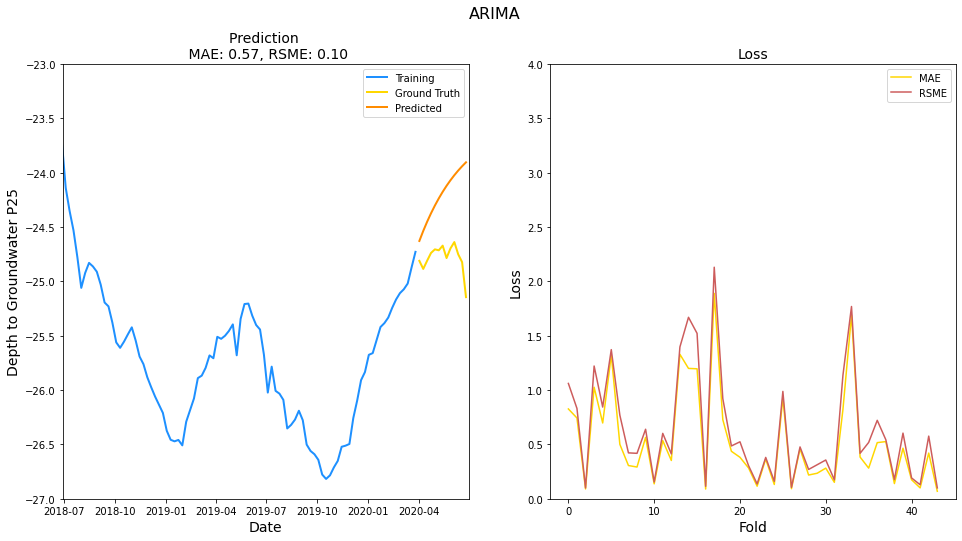

In [11]:
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rsme = []

for valid_quarter_id in range(2, N_SPLITS):
    # 准备训练集和验证集数据
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # 拟合ARIMA模型
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()
    
    # 用拟合好的模型做预测
    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    # 计算评价指标
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))


# 拟合ARIMA模型
model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

# 用拟合好的模型做预测
y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')

### 多变量时间序列模型

#### Vector Auto Regression (VAR)

VAR模型扩充了只能使用一个变量的自回归模型（AR模型），使容纳大于1个变量，因此经常用在多变量时间序列模型的分析上。

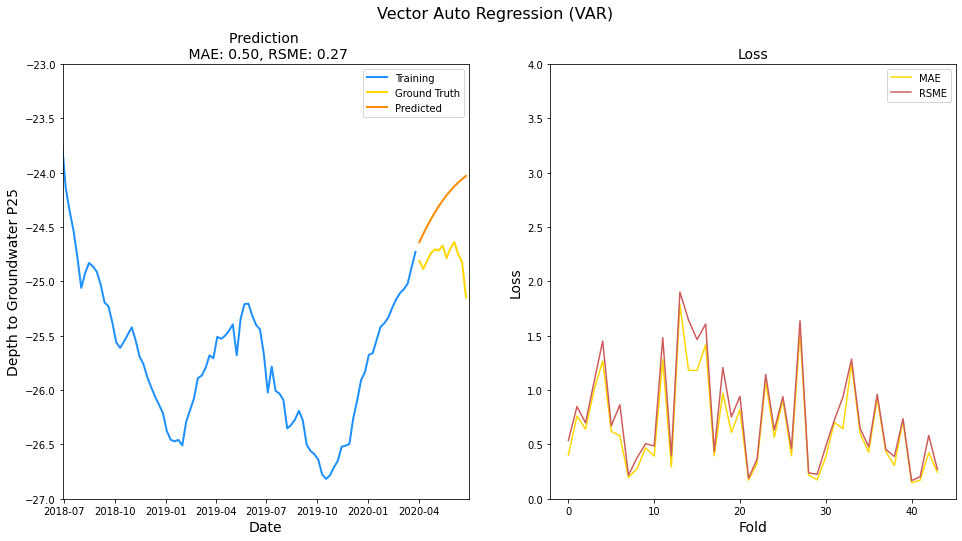

In [12]:
from statsmodels.tsa.api import VAR

score_mae = []
score_rsme = []

features = ['Temperature', 'Drainage_Volume', 'River_Hydrometry', 'Rainfall']
for valid_quarter_id in range(2, N_SPLITS):
    # 准备训练集和验证集数据
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    X_train, X_valid = X.iloc[train_index][features], X.iloc[valid_index][features]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # 拟合VAR模型
    model = VAR(pd.concat([y_train, X_train], axis=1))
    model_fit = model.fit()
    lag_order = model_fit.k_ar

    # 用拟合好的模型做预测
    y_valid_pred = model_fit.forecast(y=pd.concat([y_train, X_train], axis=1).values[-lag_order:], steps=len(X_valid))
    y_valid_pred = pd.Series(y_valid_pred[:, 0])

    # 计算评价指标
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# 拟合VAR模型
model = VAR(pd.concat([y, X[features]], axis=1))
model_fit = model.fit()
lag_order = model_fit.k_ar

# 用拟合好的模型做预测
y_pred = model_fit.forecast(y=pd.concat([y, X[features]], axis=1).values[-lag_order:], steps=len(X_valid))
y_pred = pd.Series(y_pred[:, 0])

plot_approach_evaluation(y_pred, score_mae, score_rsme, 'Vector Auto Regression (VAR)')